# 1. Build your own convolutional neural network using pytorch

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class DogHeartCNN(nn.Module):
    def __init__(self, num_classes=3):  # Updated for 3 classes
        super(DogHeartCNN, self).__init__()

        # Convolutional layers
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)

        # Batch Normalization
        self.bn1 = nn.BatchNorm2d(32)
        self.bn2 = nn.BatchNorm2d(64)
        self.bn3 = nn.BatchNorm2d(128)

        # Pooling layer
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)

        # Fully connected layers
        self.fc1 = nn.Linear(128 * 16 * 16, 512)  # Adjust based on image size
        self.fc2 = nn.Linear(512, 128)
        self.fc3 = nn.Linear(128, num_classes)  # 3 output classes

        # Dropout
        self.dropout = nn.Dropout(0.3)

    def forward(self, x):
        x = self.pool(F.relu(self.bn1(self.conv1(x))))
        x = self.pool(F.relu(self.bn2(self.conv2(x))))
        x = self.pool(F.relu(self.bn3(self.conv3(x))))

        x = x.view(x.size(0), -1)  # Flatten the tensor
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        x = self.fc3(x)  # No activation, handled in loss function (CrossEntropyLoss)

        return x

# Model initialization
model = DogHeartCNN(num_classes=3)
print(model)


DogHeartCNN(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=32768, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=3, bias=True)
  (dropout): Dropout(p=0.3, inplace=False)
)


# 2. Train your model using dog heart dataset (you may need to use  Google Colab (or Kaggle) with GPU to train your code)

### (1) use torchvision.datasets.ImageFolder for the training dataset
### (2) use custom dataloader for test dataset (return image tensor and file name)

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [38]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

# Define transformations
transform = transforms.Compose([
    transforms.Resize((128, 128)),  # Resize images to 128x128
    transforms.ToTensor(),          # Convert images to tensors
    transforms.Normalize([0.5], [0.5])  # Normalize (adjust if needed)
])

# Paths
train_dir = "/content/drive/My Drive/Dog_heart/Dog_heart/Train"
valid_dir = "/content/drive/My Drive/Dog_heart/Dog_heart/Valid"

# Load datasets
train_dataset = datasets.ImageFolder(root=train_dir, transform=transform)
valid_dataset = datasets.ImageFolder(root=valid_dir, transform=transform)

# DataLoaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=2)
valid_loader = DataLoader(valid_dataset, batch_size=32, shuffle=False, num_workers=2)

# Class names
class_names = train_dataset.classes
print("Classes:", class_names)


Classes: ['Large', 'Normal', 'Small']


In [4]:
import os
from torch.utils.data import Dataset
from PIL import Image

# Define a custom dataset for testing
class DogHeartTestDataset(Dataset):
    def __init__(self, test_dir, transform=None):
        self.test_dir = test_dir
        self.transform = transform
        self.image_files = [f for f in os.listdir(test_dir) if f.endswith(('png', 'jpg', 'jpeg'))]

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_name = self.image_files[idx]
        img_path = os.path.join(self.test_dir, img_name)
        image = Image.open(img_path).convert("RGB")

        if self.transform:
            image = self.transform(image)

        return image, img_name  # Return both image tensor and filename

# Test dataset and DataLoader
test_dir = "/content/drive/My Drive/Test/Test"
test_dataset = DogHeartTestDataset(test_dir, transform=transform)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Check test data
for img, filename in test_loader:
    print("Batch shape:", img.shape)
    print("File names:", filename[:5])  # Print first 5 filenames
    break


Batch shape: torch.Size([32, 3, 128, 128])
File names: ('1624.png', '100.png', '1627.png', '1631.png', '1628.png')


In [5]:
import torch

# Check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# Move the model to GPU
model = DogHeartCNN(num_classes=3).to(device)


Using device: cpu


In [6]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()  # Suitable for multi-class classification
optimizer = optim.Adam(model.parameters(), lr=0.0001)  # Adam optimizer


In [8]:
num_epochs = 10  # Change based on performance
best_val_acc = 0.0

for epoch in range(num_epochs):
    model.train()  # Set model to training mode
    running_loss = 0.0
    correct, total = 0, 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)  # Move to GPU

        optimizer.zero_grad()  # Clear gradients
        outputs = model(images)  # Forward pass
        loss = criterion(outputs, labels)  # Compute loss
        loss.backward()  # Backpropagation
        optimizer.step()  # Update weights

        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    train_acc = 100 * correct / total
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(train_loader):.4f}, Train Acc: {train_acc:.2f}%")

    # Validation
    model.eval()  # Set model to evaluation mode
    correct, total = 0, 0
    with torch.no_grad():
        for images, labels in valid_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    val_acc = 100 * correct / total
    print(f"Validation Accuracy: {val_acc:.2f}%\n")

    # Save the model if validation accuracy is the best so far
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), 'best_model.pth')
        print(f"Saved best model with validation accuracy: {best_val_acc:.2f}%")


print("Training Complete!")


Epoch [1/10], Loss: 0.3405, Train Acc: 85.36%
Validation Accuracy: 70.50%

Saved best model with validation accuracy: 70.50%
Epoch [2/10], Loss: 0.2772, Train Acc: 89.07%
Validation Accuracy: 69.50%

Epoch [3/10], Loss: 0.2432, Train Acc: 91.79%
Validation Accuracy: 71.00%

Saved best model with validation accuracy: 71.00%
Epoch [4/10], Loss: 0.1775, Train Acc: 94.36%
Validation Accuracy: 67.00%

Epoch [5/10], Loss: 0.1375, Train Acc: 96.36%
Validation Accuracy: 69.00%

Epoch [6/10], Loss: 0.1056, Train Acc: 97.14%
Validation Accuracy: 69.50%

Epoch [7/10], Loss: 0.0763, Train Acc: 98.79%
Validation Accuracy: 71.00%

Epoch [8/10], Loss: 0.0794, Train Acc: 98.36%
Validation Accuracy: 69.50%

Epoch [9/10], Loss: 0.0511, Train Acc: 99.07%
Validation Accuracy: 70.00%

Epoch [10/10], Loss: 0.0345, Train Acc: 99.64%
Validation Accuracy: 69.50%

Training Complete!


# 3. Evaluate your model using the developed software

In [ ]:
import pandas as pd

model.load_state_dict(torch.load('best_model.pth'))  # Load the saved weights
model.to(device)
model.eval()


# Store predictions
predictions = []

with torch.no_grad():
    for images, filenames in test_loader:
        images = images.to(device)  # Move images to GPU
        outputs = model(images)  # Get predictions
        _, predicted = torch.max(outputs, 1)  # Get class index (numerical)

        # Store filename and numerical label
        for filename, label in zip(filenames, predicted.cpu().numpy()):
            predictions.append([filename, label])

# Convert to a DataFrame and save as CSV
df = pd.DataFrame(predictions, columns=["image_name", "predicted_label"])
df.to_csv("predictions.csv", index=False)

print("Predictions saved as predictions.csv!")


Predictions saved as predictions.csv!


# 4. Compare results with [RVT paper](https://www.nature.com/articles/s41598-023-50063-x). Requirement: performance is better than VGG16: 75%

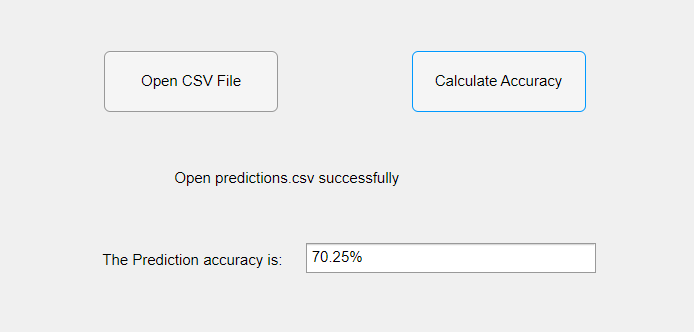

# 5. Write a four-page paper report using the shared LaTex template. Upload your paper to ResearchGate or Arxiv, and put your paper link and GitHub weight link here.

https://www.researchgate.net/publication/390177749_Custom_Convolutional_Neural_Network_for_Dog_Heart_Classification
https://github.com/AryaNandakumar/Custom-Convolutional-Neural-Network-for-Dog-Heart-Classification

# 6. Grading rubric

(1). Code ------- 20 points (you also need to upload your final model as a pt file)

(2). Grammer ---- 20 points

(3). Introduction & related work --- 10 points


(4). Method  ---- 20 points

(5). Results ---- 20 points

     > = 75 % -->10 points
     < 55 % -->0 points
     >= 55 % & < 75% --> 0.5 point/percent
     

(6). Discussion - 10 points